# How much is your Fiat 500 worth? 🚗💨 - Price Prediction

<br />

<center>
<img src="https://i0.wp.com/perezloizeau.com/wp-content/uploads/2015/09/Fiat-500-2015_1.jpg?w=630" alt="25746" border="0" width="50%" height="50%">
</center>

## Skills: Python, Web scraping, Linear Regression

Available in [GitHub](https://nico-mori.github.io)

<a id='content' />

## Contents

1. [Introduction](#intro)
2. [Web Scraping](#scraping)
3. [Data Cleansing](#cleansing)
4. [EDA](#eda)
5. [Preprocessing](#processing)
6. [Model Building](#models)

<a id='intro' />

## Introduction
[(back to top)](#content)

The Fiat 500 or cinquecento, is one of the most iconic Italian cars ever produced (there was even one displayed at [New York's Museum of Modern Art](https://www.moma.org/collection/works/220647)). In 2007, 50 years after the original model was lanched, Fiat launched a new generation that has been among the most sold cars in Italy ever since.

The goal of this project is to try to predict how much money is one of this very likable cars worth on the second hand market in Italy depending on different variables such as mileage (expressed in kilometers), year and equipement.

In [33]:
#Importing libraries
import pandas as pd
import numpy as np
import re
import unidecode

from tqdm.notebook import tqdm
import time

from selenium import webdriver
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

<a id='scraping' />

## Web Scraping
[(back to top)](#content)

There were some car prices datasets available on the internet, but there was no information about their reliability, which is why we will gather the data directly from an Italian used car website using web scraping.

In [ ]:
#Load webdriver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

#Open page
driver.get('https://www.automobile.it/fiat-500-usate?anno_fino_a=2021&immatricolazione=2007')
time.sleep(4)

#Close location popup
driver.find_element(by=By.XPATH, value='//*[@id="modal"]/div/div/div/div/div[2]/button[1]').click()
time.sleep(2)

#Close cookies popup
driver.find_element(by=By.XPATH, value='//*[@id="onetrust-accept-btn-handler"]').click()
time.sleep(2)

Since the data is spread across multiple pages (each page contains 20 cars) we will use a loop to iterate over all the pages and append the data to a single dataframe. The dataframe will then be saved as a tsv file (some titles contain commas, a complication for the csv format).

The process takes a while to run (about 15 minutes) so we can use a [progress bar](https://tqdm.github.io) to track it and know how long until it is ready.


In [ ]:
#Empty list and df
temp=[]
df = pd.DataFrame(columns=['Title', 'Month_Year', 'Kms', 'Fuel', 'Transmission', 'Price', 'Link'])

#Number of pages
npages = int(driver.find_element(by=By.XPATH, value='//*[@id="__next"]/main/div[3]/div/div[3]/div[2]/div[3]/div[1]/button[4]').text)

for h in tqdm(range(npages), position = 0, desc='1st loop'):
    
    temp_df = pd.DataFrame()

    #Title
    titles=driver.find_elements(by=By.XPATH, value='//*[@class="jsx-2059509079 Card__Title font-base"]')
    for title in titles: temp.append(title.text)
    
    temp_df['Title'] = temp
    temp.clear()
    
    #Specs
    specs=driver.find_elements(by=By.XPATH, value='//*[@class="jsx-2059509079 Card__BoxInfo"]')
    
    for i in range(len(specs)):
        spec = specs[i].text.split('\n')
    
        to_remove = ['Usato','Unico proprietario','2 Proprietari','3 Proprietari','4 Proprietari','Più di 4 Proprietari']
        for j in to_remove:
            while j in spec: spec.remove(j)
    
        temp.append(spec)
    
    temp_df = pd.concat([temp_df, pd.DataFrame(temp, columns=['Price', 'Month_Year', 'Kms', 'Fuel', 'Transmission'])], axis=1)
    temp.clear()

    #Append data to df
    df = pd.concat([temp_df, df], axis=0, ignore_index=True)    
    
    #Switch to next page or close
    if h < max(range(npages)):
        driver.find_element(by=By.XPATH, value='//*[@class="jsx-2138479547 font-base xxsmall primary-orange styled"]').click()
        time.sleep(3)
    else: driver.close()
    
  
df.to_csv('fiat500_rawdata.tsv', sep='\t', index=False)

<a id='cleansing' />

## Data Cleansing
[(back to top)](#content)

Once the raw data is ready, it is necessary to clean it. There are some duplicate rows because some car dealers list the same car multiple times in different cities, so we start by removing them. 

In [ ]:
fiat_500 = df

In [70]:
#Read df
fiat_500 = pd.read_csv('fiat500_rawdata.tsv', sep='\t') 

#Drop duplicated rows
fiat_500 = (fiat_500
    .drop_duplicates()
    .reset_index(drop=True)
    )

#Check df
fiat_500.head()

,Title,Price,Month_Year,Kms,Fuel,Transmission
0,FIAT 500C 1.2 Riva,€ 16.900,Dicembre 2016,40.000 km,Benzina - Euro 6,Manuale
1,"FIAT 500C CABRIO 1.2 ""S"" Bellissima!!! ADATTA ...",€ 12.470,Settembre 2014,76.000 km,Benzina - Euro 6,Manuale
2,Fiat 500 La Prima Berlina,€ 27.900,Gennaio 2021,1.300 km,Elettrico - Euro 0,Manuale
3,FIAT 500 1.2 Lounge,€ 7.300,Aprile 2008,147.236 km,Benzina - Euro 4,Manuale
4,FIAT 500 1.0 Hybrid Connect PER NEOPATENTATI,€ 17.800,Aprile 2021,14.884 km,Ibrido - Euro 6,Manuale


### Categorical variables

While there is not a specific variable with the equipement version of each cinquecento, we can extract them from their title in the listing. Besides the conventional model, there is also the cabrio model, which can also be deducted from the the same listing titles and will be used to create a new variable.

Last but not least, we do some cleaning in the Fuel and Transmission variables.

In [71]:
#Equipment version extraction
conditions = [fiat_500['Title'].str.contains('Lounge', case=False), 
              fiat_500['Title'].str.contains('Pop', case=False), 
              fiat_500['Title'].str.contains('Collezione', case=False),
              fiat_500['Title'].str.contains('Dolcevita', case=False),
              fiat_500['Title'].str.contains('Riva', case=False), 
              fiat_500['Title'].str.contains('Cult', case=False), 
              fiat_500['Title'].str.contains('Icon', case=False),
              fiat_500['Title'].str.contains('Star', case=False), 
              fiat_500['Title'].str.contains('Sport', case=False), 
              fiat_500['Title'].str.contains('S ', case=False), 
              fiat_500['Title'].str.contains(' S', case=False),  
              fiat_500['Title'].str.contains('"S"', case=False)]

choices = ['Lounge','Pop','Collezione','Dolcevita','Riva','Cult','Icon','Star','Sport','Sport','Sport','Sport']
fiat_500['Version'] = np.select(conditions, choices, default='No info')

#Cabrio variable generation
fiat_500['Cabrio'] =  np.where(fiat_500['Title'].str.contains('Cabrio | 500C | C ', case=False), 'Yes', 'No')

#Fuel cleansing
fiat_500['Fuel'] = [i.replace(' - Euro ','') for i in fiat_500['Fuel']]
fiat_500['Fuel'] = fiat_500['Fuel'].str.replace('\d+', '', regex=True)
fiat_500['Fuel'] = [i.replace('Metano','GPL') for i in fiat_500['Fuel']]

#Transmission
fiat_500['Transmission'] = [i.replace('Semiautomatico','Automatico') for i in fiat_500['Transmission']]

### Numeric variables

This is the easy part, we remove non numeric characters and parse the columns as numeric.

In [72]:
#Formatting numeric variables
fiat_500['Kms'] = [str(i).replace(' km','') for i in fiat_500['Kms']]
fiat_500['Kms'] = pd.to_numeric(fiat_500['Kms'])*1000

fiat_500['Price'] = [i.replace('€ ','') for i in fiat_500['Price']]
fiat_500['Price'] = pd.to_numeric(fiat_500['Price'])*1000

fiat_500['Year'] = fiat_500['Month_Year'].str.strip().str[-4:]
fiat_500['Year'] = pd.to_numeric(fiat_500['Year'])

With all the cleaning and formatting done, we remove the rows that have no information about the version and the columns that are no longer useful. 

In [73]:
#Dropping unnecesary rows
fiat_500 = fiat_500[~fiat_500['Title'].str.contains('Abarth', case=False)]
fiat_500 = fiat_500[fiat_500['Version']!='No info']

#Dropping unnecessary columns
fiat_500 = fiat_500.drop(['Month_Year', 'Title'], axis=1)

#Clean df check
fiat_500.head()

,Price,Kms,Fuel,Transmission,Version,Cabrio,Year
0,16900.0,40000.0,Benzina,Manuale,Riva,Yes,2016
1,12470.0,76000.0,Benzina,Manuale,Sport,Yes,2014
3,7300.0,147236.0,Benzina,Manuale,Lounge,No,2008
5,13800.0,60000.0,Benzina,Automatico,Lounge,No,2015
6,18800.0,22500.0,Benzina,Automatico,Lounge,Yes,2020


<a id='eda' />

## EDA
[(back to top)](#content)

Having a quick look at the numeric variables we can see that there are some extreme values of price and mileage that can distort the analysis, so they will be removed. 

Our intuition tells us that both mileage and year are important variables. Using a 3D scatterplot we see that they are both highly related with the car price, although the year has a more linear relation (the price does not change much regarding the mileage after the 100k km). There also is a a group with a higher price in the most recent years, which requires further investigation. 

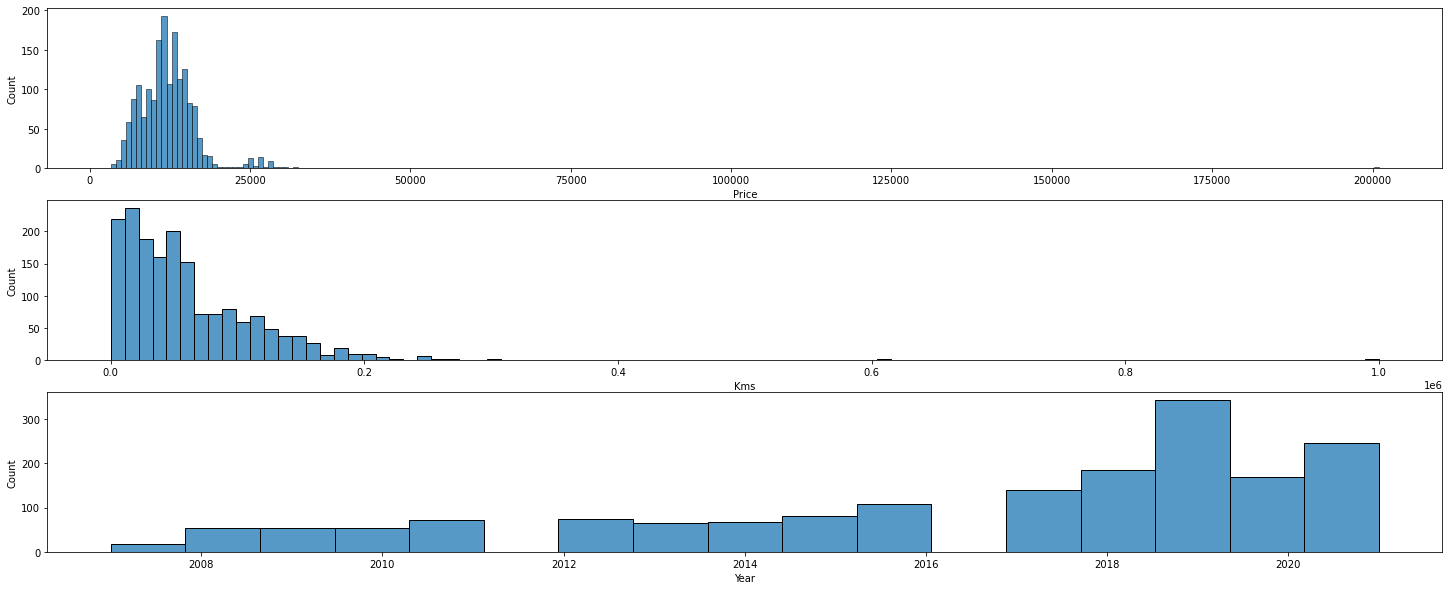

In [74]:
#Numeric variable distribution
temp = fiat_500.select_dtypes(['int64','float64'])

fig, axes = plt.subplots(3,1, figsize=(25,10))
axes = np.ravel(axes)

for h,i in enumerate(temp.columns):
    sns.histplot(data=temp[i], ax=axes[h])

In [75]:
#Remove outliers
fiat_500 = (fiat_500[(np.abs(stats.zscore(fiat_500[['Price','Kms']])) < 3).all(axis=1)]
    .reset_index(drop=True)
)

#3d scatterplot
px.scatter_3d(fiat_500, x='Year', y='Kms', z='Price', opacity=0.5) # color='Fuel',



Looking at the categorical variables we can see that none of them is uniformely distributed, but for it does not represent a problem. There is one thing that catches the attention: some cars are electric and this type of cars usual costs considerably more than the ones powered by fossil fuels, which might explain the group of cars with a higher price that we previously saw.

A quick drill down on the prices by fuel on the most recent cars confirms the theory. Electric cars move on a higher price range, meaning that this is another factor of importante when predicting the price.

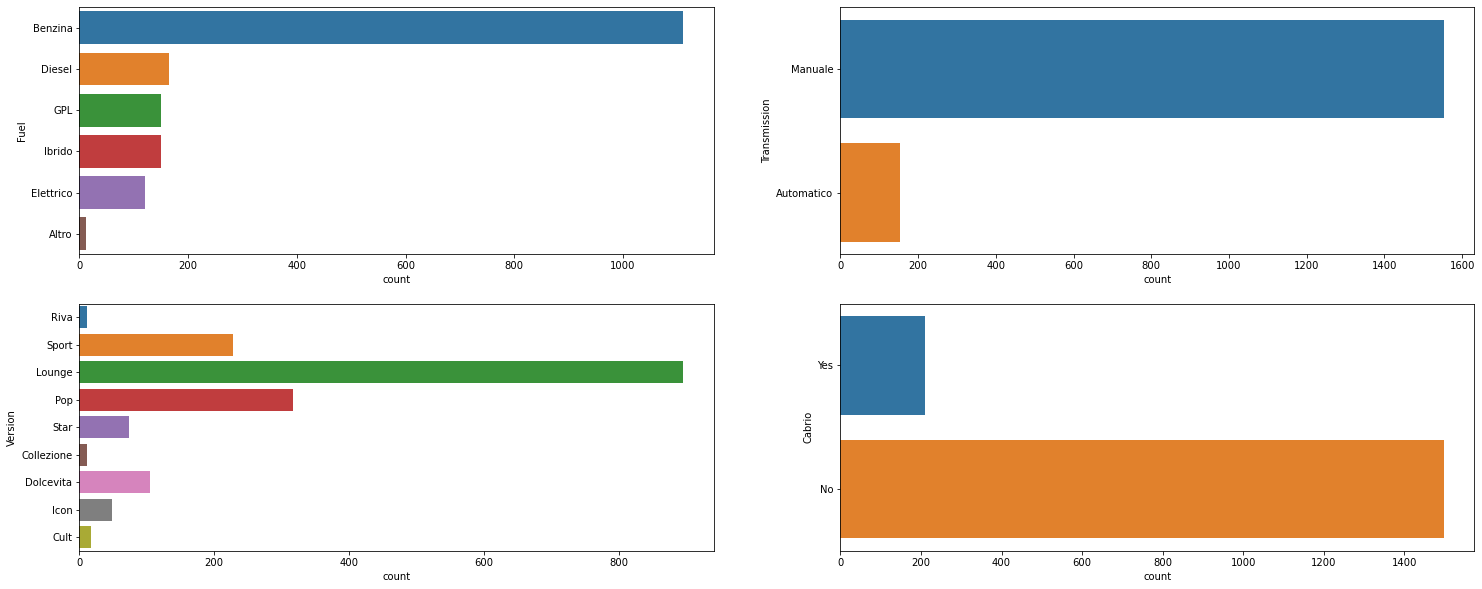

In [76]:
#Categorical variable distribution
temp = fiat_500.select_dtypes('object')

fig, axes = plt.subplots(2,2, figsize=(25,10))
axes = np.ravel(axes)

for h,i in enumerate(temp.columns):
    sns.countplot(data=temp, y=i, ax=axes[h])

<AxesSubplot:xlabel='Price', ylabel='Fuel'>

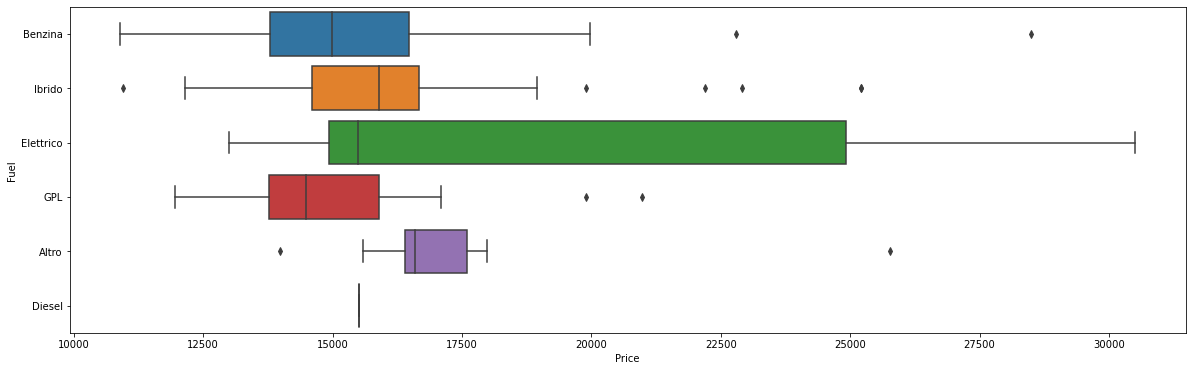

In [89]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=fiat_500[(fiat_500['Year']>=2020)], y='Fuel', x='Price')

<a id='processing' />

## Preprocessing
[(back to top)](#content)

After exploring our data it is time to prepare it for the model. We need to convert the categorical variables to dummy variables, as machine learning algorithms can handle numerical data only.

We also check the correlations between variables, to get an idea about what variables may have a bigger impact over price and to detect [multicollinearity](https://towardsdatascience.com/multicollinearity-why-is-it-bad-5335030651bf).

Then we split the data into a training and a test set and finally we scale it, to avoid excesive influence from variables with bigger magnitudes.

In [9]:
df_pre = fiat_500

In [11]:
#Convert categorical variables
df_pre = pd.get_dummies(df_pre, columns=['Transmission','Cabrio'], drop_first=True) #Binary variables
df_pre = pd.get_dummies(df_pre, drop_first=False) #Non binary variables


<AxesSubplot:>

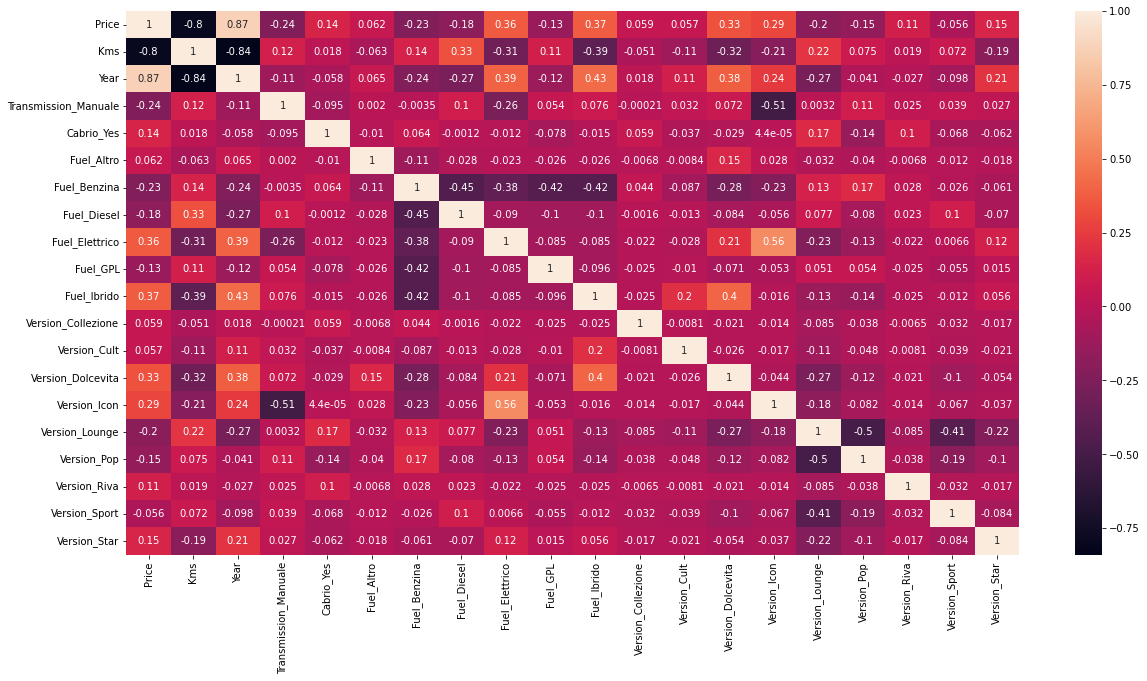

In [12]:
#Correlacion entre variables numericas y variable objetivo
plt.figure(figsize=(20, 10))
sns.heatmap(df_pre.corr(method='spearman'), annot = True)

In [13]:
#Dividing variables and target
X, y = df_pre.drop(['Price'], axis=1), df_pre.Price

#Dividing train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
#Creating instance and fitting
scaler = MinMaxScaler()
scaler.fit(X_train)

#Scaling and transforming in train df
X_train_s = scaler.transform(X_train)
X_train_s = pd.DataFrame(X_train_s, columns=X_train.columns)

#Scaling and transforming in test df
X_test_s = scaler.transform(X_test)
X_test_s = pd.DataFrame(X_test_s, columns=X_test.columns)

<a id='models' />

## Model Building
[(back to top)](#content)

When building the model to predict the price of our famous car we need to take into account an important thing: we are not building a model for the sake of doing it, but rather to understand how can the price be influenced by the variables we gathered, so it is important that at the end of the process we are able to explain this things in a non super technical way.

### Linear Regression

In [15]:
#Instantiate
lr = LinearRegression()  
lr.fit(X_train_s, y_train)

#Predicting
y_pred = lr.predict(X_test_s)

#Evaluating
print(f'R2 score: {round(r2_score(y_true=y_test, y_pred=y_pred), 3)}')
print(f'Mean squared error: {round(mean_squared_error(y_true=y_test, y_pred=y_pred), 3)}')


R2 score:0.872
Mean squared error:2024653.703


### Decision Tree Regressor

In [43]:
#Entrenamos el modelo de árbol de decisión. 
tr = DecisionTreeRegressor(random_state=0, max_depth=5)
tr.fit(X_train_s, y_train)

#Predicting
y_pred = tr.predict(X_test_s)

#Evaluating
print(f'R2 score: {round(r2_score(y_true=y_test, y_pred=y_pred), 3)}')
print(f'Mean squared error: {round(mean_squared_error(y_true=y_test, y_pred=y_pred), 3)}')

R2 score: 0.844
Mean squared error: 2463128.879


In [44]:
#Principales variables
feature_importance = pd.DataFrame({"feature":X.columns, "importance": tr.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance', ascending=False).reset_index(drop=True)

feature_importance.head(5)

,feature,importance
0,Year,0.637177
1,Version_Icon,0.313462
2,Cabrio_Yes,0.024900
3,Kms,0.018805
4,Version_Riva,0.003241


In [ ]:
#https://towardsdatascience.com/predicting-car-price-using-machine-learning-8d2df3898f16